In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
%%time
simple_df = pd.read_csv('./국토교통부_건축물대장_총괄표제부/총괄표제부_simple_features.csv')
print(simple_df.shape)
simple_df.head()

(42149, 30)
Wall time: 187 ms


,지번주소,기준년월,기준년월_최초사용승년도,주소별_최초생성년도,건물_명,외필지_수,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),주_용도,기타_용도,총호수,주_건축물_수,부속_건축물_수,부속_건축물_면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),총_주차_수,에너지_EPI점수,친환경_건축물_인증점수,지능형_건축물_인증점수
0,서울특별시 강남구 개포동 1193-5,201812,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
1,서울특별시 강남구 개포동 1193-5,201912,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
2,서울특별시 강남구 개포동 1193-5,202011,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
3,서울특별시 강남구 개포동 12-0,201412,NaN,2012,"대치,대청 아파트",0,0.0,15324.37,0.00,223939.0,211555.54,0.00,공동주택,주거시설 근린생활시설,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0
4,서울특별시 강남구 개포동 12-0,201512,NaN,2012,"대치,대청 아파트",0,0.0,15324.37,0.00,223939.0,211555.54,0.00,공동주택,주거시설 근린생활시설,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0


In [28]:
%%time
bdinfo_inter_df = pd.read_csv('./국토교통부_건축물대장_표제부/bdinfo_baseline_maindata_inter_checkpoint_1.csv')
print(bdinfo_inter_df.shape)

<string>:2: DtypeWarning: Columns (36) have mixed types.Specify dtype option on import or set low_memory=False.


(935418, 52)
Wall time: 8.04 s


In [4]:
bdinfo_except_df = bdinfo_inter_df[bdinfo_inter_df['지번주소'].isin(simple_df['지번주소'].unique()) == False]
print(bdinfo_except_df.shape)
bdinfo_except_df.head()

(684442, 52)


,관리_건축물대장_PK,대장_구분,대장_종류,건물_명,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),사용승인_일,에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,기준년도,지번주소,총세대수,대장구분명,사용승인년도,생성년도,기준년도_최초사용승인일,주소별_최초생성년도
0,11440-21639,집합,표제부,NaN,0,NaN,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트 평스라브,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20040323.0,NaN,0.0,0,NaN,0,NaN,0,20101230,2014,서울특별시 마포구 서교동 484-16,4,일반,2004.0,2010,2004.0,2010
1,11590-100182663,집합,표제부,두성쉐르빌,1,NaN,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080826.0,NaN,0.0,0,NaN,0,NaN,0,20110119,2014,서울특별시 동작구 상도동 302-28,10,일반,2008.0,2011,2008.0,2011
2,11320-100182241,집합,표제부,NaN,0,NaN,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080721.0,NaN,0.0,0,NaN,0,NaN,0,20110202,2014,서울특별시 도봉구 쌍문동 380-24,4,일반,2008.0,2011,2008.0,2011
3,11440-32174,집합,표제부,대현하이빌,0,NaN,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,평스라브,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050901.0,NaN,0.0,0,NaN,0,NaN,0,20110125,2014,서울특별시 마포구 성산동 200-260,8,일반,2005.0,2011,2005.0,2011
5,11380-28561,집합,표제부,NaN,0,NaN,주건축물,167.90,100.600,59.92,390.730,390.730,232.72,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(8세대),(철근)콘크리트,평 스라브,12.50,5,0,0,0,0,0.0,390.730,0,0.0,0,0.0,0,0.00,6,0.0,20020708.0,NaN,0.0,0,NaN,0,NaN,0,20100825,2014,서울특별시 은평구 응암동 88-17,8,일반,2002.0,2010,2002.0,2010


In [6]:
bdinfo_except_df['총_주차_수'] = bdinfo_except_df['옥내_기계식_대수(대)'] + bdinfo_except_df['옥외_기계식_대수(대)'] + bdinfo_except_df['옥내_자주식_대수(대)'] + bdinfo_except_df['옥외_자주식_대수(대)']

In [7]:
bdinfo_except_df['대장_구분'].value_counts()

집합    643030
일반     41412
Name: 대장_구분, dtype: int64

In [8]:
normal_df = bdinfo_except_df[bdinfo_except_df['대장_구분'] == '일반']
print(normal_df.shape)

(41412, 53)


In [9]:
normal_df['주_용도'].value_counts()

단독주택          33003
제1종근린생활시설      3231
제2종근린생활시설      2838
숙박시설            415
공장              361
업무시설            247
노유자시설           242
공동주택            227
창고시설            220
자동차관련시설         176
교육연구시설          133
종교시설             88
근린생활시설           71
위험물저장및처리시설       47
판매시설             37
의료시설             33
문화및집회시설          24
위락시설              9
수련시설              6
동.식물관련시설          2
운동시설              2
Name: 주_용도, dtype: int64

In [56]:
group_df = bdinfo_except_df[bdinfo_except_df['대장_구분'] == '집합']
print(group_df.shape)
group_df.head()

(643030, 53)


,관리_건축물대장_PK,대장_구분,대장_종류,건물_명,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),사용승인_일,에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,기준년도,지번주소,총세대수,대장구분명,사용승인년도,생성년도,기준년도_최초사용승인일,주소별_최초생성년도,총_주차_수
0,11440-21639,집합,표제부,NaN,0,NaN,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트 평스라브,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20040323.0,NaN,0.0,0,NaN,0,NaN,0,20101230,2014,서울특별시 마포구 서교동 484-16,4,일반,2004.0,2010,2004.0,2010,4
1,11590-100182663,집합,표제부,두성쉐르빌,1,NaN,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080826.0,NaN,0.0,0,NaN,0,NaN,0,20110119,2014,서울특별시 동작구 상도동 302-28,10,일반,2008.0,2011,2008.0,2011,10
2,11320-100182241,집합,표제부,NaN,0,NaN,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080721.0,NaN,0.0,0,NaN,0,NaN,0,20110202,2014,서울특별시 도봉구 쌍문동 380-24,4,일반,2008.0,2011,2008.0,2011,4
3,11440-32174,집합,표제부,대현하이빌,0,NaN,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,평스라브,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050901.0,NaN,0.0,0,NaN,0,NaN,0,20110125,2014,서울특별시 마포구 성산동 200-260,8,일반,2005.0,2011,2005.0,2011,8
5,11380-28561,집합,표제부,NaN,0,NaN,주건축물,167.90,100.600,59.92,390.730,390.730,232.72,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(8세대),(철근)콘크리트,평 스라브,12.50,5,0,0,0,0,0.0,390.730,0,0.0,0,0.0,0,0.00,6,0.0,20020708.0,NaN,0.0,0,NaN,0,NaN,0,20100825,2014,서울특별시 은평구 응암동 88-17,8,일반,2002.0,2010,2002.0,2010,6


In [57]:
group_df['기준년도_총주차수'] = group_df[['지번주소', '기준년도', '총_주차_수']].groupby(['지번주소', '기준년도']).transform('sum')['총_주차_수']

In [58]:
group_df['총호수'] = group_df[['지번주소', '기준년도', '총세대수']].groupby(['지번주소', '기준년도']).transform('sum')['총세대수']

In [59]:
group_df['주_부속_구분'].value_counts()

주건축물     639598
부속건축물      3428
Name: 주_부속_구분, dtype: int64

In [60]:
group_df['주건축물'] = group_df['주_부속_구분'].apply(lambda x: 1 if x == '주건축물' else 0)

In [61]:
group_df['주건축물수'] = group_df[['지번주소', '기준년도', '주건축물']].groupby(['지번주소', '기준년도']).transform('sum')['주건축물']

In [62]:
group_df['부속건축물수'] = group_df[['지번주소', '기준년도', '부속_건축물_수']].groupby(['지번주소', '기준년도']).transform('sum')['부속_건축물_수']

In [71]:
group_df['부속건축물면적'] = group_df[['지번주소', '기준년도', '부속_건축물_면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['부속_건축물_면적(㎡)']

In [63]:
group_df['총외필지수'] = group_df[['지번주소', '기준년도', '외필지_수']].groupby(['지번주소', '기준년도']).transform('sum')['외필지_수']

In [64]:
group_df['총건축면적'] = group_df[['지번주소', '기준년도', '건축_면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['건축_면적(㎡)']

In [65]:
group_df['총연면적'] = group_df[['지번주소', '기준년도', '연면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['연면적(㎡)']

In [66]:
group_df['총용적률연면적'] = group_df[['지번주소', '기준년도', '용적_률_산정_연면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['용적_률_산정_연면적(㎡)']

In [67]:
group_df['epi점수'] = group_df[['지번주소', '기준년도', '에너지_EPI점수']].groupby(['지번주소', '기준년도']).transform('median')['에너지_EPI점수']

In [68]:
group_df['친환경점수'] = group_df[['지번주소', '기준년도', '친환경_건축물_인증점수']].groupby(['지번주소', '기준년도']).transform('median')['친환경_건축물_인증점수']

In [74]:
group_df['옥내기계식대수'] = group_df[['지번주소', '기준년도', '옥내_기계식_대수(대)']].groupby(['지번주소', '기준년도']).transform('sum')['옥내_기계식_대수(대)']
group_df['옥내기계식면적'] = group_df[['지번주소', '기준년도', '옥내_기계식_면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['옥내_기계식_면적(㎡)']

In [75]:
group_df['옥외기계식대수'] = group_df[['지번주소', '기준년도', '옥외_기계식_대수(대)']].groupby(['지번주소', '기준년도']).transform('sum')['옥외_기계식_대수(대)']
group_df['옥외기계식면적'] = group_df[['지번주소', '기준년도', '옥외_기계식_면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['옥외_기계식_면적(㎡)']

In [76]:
group_df['옥내자주식대수'] = group_df[['지번주소', '기준년도', '옥내_자주식_대수(대)']].groupby(['지번주소', '기준년도']).transform('sum')['옥내_자주식_대수(대)']
group_df['옥내자주식면적'] = group_df[['지번주소', '기준년도', '옥내_자주식_면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['옥내_자주식_면적(㎡)']

In [77]:
group_df['옥외자주식대수'] = group_df[['지번주소', '기준년도', '옥외_자주식_대수(대)']].groupby(['지번주소', '기준년도']).transform('sum')['옥외_자주식_대수(대)']
group_df['옥외자주식면적'] = group_df[['지번주소', '기준년도', '옥외_자주식_면적(㎡)']].groupby(['지번주소', '기준년도']).transform('sum')['옥외_자주식_면적(㎡)']

In [79]:
group_df['대지면적'] = group_df[['지번주소', '기준년도', '대지_면적(㎡)']].groupby(['지번주소', '기준년도']).transform('max')['대지_면적(㎡)']

In [80]:
simple_df.head()

,지번주소,기준년월,기준년월_최초사용승년도,주소별_최초생성년도,건물_명,외필지_수,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),주_용도,기타_용도,총호수,주_건축물_수,부속_건축물_수,부속_건축물_면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),총_주차_수,에너지_EPI점수,친환경_건축물_인증점수,지능형_건축물_인증점수
0,서울특별시 강남구 개포동 1193-5,201812,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
1,서울특별시 강남구 개포동 1193-5,201912,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
2,서울특별시 강남구 개포동 1193-5,202011,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
3,서울특별시 강남구 개포동 12-0,201412,NaN,2012,"대치,대청 아파트",0,0.0,15324.37,0.00,223939.0,211555.54,0.00,공동주택,주거시설 근린생활시설,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0
4,서울특별시 강남구 개포동 12-0,201512,NaN,2012,"대치,대청 아파트",0,0.0,15324.37,0.00,223939.0,211555.54,0.00,공동주택,주거시설 근린생활시설,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0


In [81]:
group_df.head()

,관리_건축물대장_PK,대장_구분,대장_종류,건물_명,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),사용승인_일,에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,기준년도,지번주소,총세대수,대장구분명,사용승인년도,생성년도,기준년도_최초사용승인일,주소별_최초생성년도,총_주차_수,기준년도_총주차수,총호수,주건축물,주건축물수,부속건축물수,총외필지수,총건축면적,총연면적,총용적률연면적,epi점수,친환경점수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,대지면적
0,11440-21639,집합,표제부,NaN,0,NaN,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트 평스라브,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20040323.0,NaN,0.0,0,NaN,0,NaN,0,20101230,2014,서울특별시 마포구 서교동 484-16,4,일반,2004.0,2010,2004.0,2010,4,4,4,1,1,0,0,105.300,393.130,385.210,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,4,46.0,177.62
1,11590-100182663,집합,표제부,두성쉐르빌,1,NaN,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080826.0,NaN,0.0,0,NaN,0,NaN,0,20110119,2014,서울특별시 동작구 상도동 302-28,10,일반,2008.0,2011,2008.0,2011,10,10,10,1,1,0,1,232.420,947.740,659.890,0.0,0.0,0.0,0,0.0,0,0.0,8,287.85,2,11.5,389.48
2,11320-100182241,집합,표제부,NaN,0,NaN,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,(철근)콘크리트,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080721.0,NaN,0.0,0,NaN,0,NaN,0,20110202,2014,서울특별시 도봉구 쌍문동 380-24,4,일반,2008.0,2011,2008.0,2011,4,4,4,1,1,0,0,81.085,268.165,268.165,0.0,0.0,0.0,0,0.0,0,0.0,3,0.00,1,0.0,208.00
3,11440-32174,집합,표제부,대현하이빌,0,NaN,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택,(철근)콘크리트,평스라브,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050901.0,NaN,0.0,0,NaN,0,NaN,0,20110125,2014,서울특별시 마포구 성산동 200-260,8,일반,2005.0,2011,2005.0,2011,8,8,8,1,1,0,0,180.380,627.880,627.880,0.0,0.0,0.0,0,0.0,0,0.0,7,80.50,1,11.5,314.00
5,11380-28561,집합,표제부,NaN,0,NaN,주건축물,167.90,100.600,59.92,390.730,390.730,232.72,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(8세대),(철근)콘크리트,평 스라브,12.50,5,0,0,0,0,0.0,390.730,0,0.0,0,0.0,0,0.00,6,0.0,20020708.0,NaN,0.0,0,NaN,0,NaN,0,20100825,2014,서울특별시 은평구 응암동 88-17,8,일반,2002.0,2010,2002.0,2010,6,6,8,1,1,0,0,100.600,390.730,390.730,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,6,0.0,167.90


In [86]:
bdinfo_simple_df = group_df[['지번주소', '기준년도', '기준년도_최초사용승인일', '주소별_최초생성년도', '총외필지수', '대지면적',
                             '총건축면적', '총연면적', '총용적률연면적', '총호수', '주건축물수', '부속건축물수', '부속건축물면적',
                             '옥내기계식대수', '옥내기계식면적', '옥외기계식대수', '옥외기계식면적',
                             '옥내자주식대수', '옥내자주식면적', '옥외자주식대수', '옥외자주식면적',
                             '기준년도_총주차수', 'epi점수', '친환경점수'
                            ]]
print(bdinfo_simple_df.shape)

(643030, 24)


In [87]:
bdinfo_simple_df.isna().sum()

지번주소              0
기준년도              0
기준년도_최초사용승인일    754
주소별_최초생성년도        0
총외필지수             0
대지면적              0
총건축면적             0
총연면적              0
총용적률연면적           0
총호수               0
주건축물수             0
부속건축물수            0
부속건축물면적           0
옥내기계식대수           0
옥내기계식면적           0
옥외기계식대수           0
옥외기계식면적           0
옥내자주식대수           0
옥내자주식면적           0
옥외자주식대수           0
옥외자주식면적           0
기준년도_총주차수         0
epi점수             0
친환경점수             0
dtype: int64

In [88]:
bdinfo_simple_df['기준년도_최초사용승인일'].fillna(bdinfo_simple_df['주소별_최초생성년도'], inplace=True)
bdinfo_simple_df.drop(columns=['주소별_최초생성년도'], inplace=True)

In [89]:
bdinfo_simple_df.drop_duplicates(inplace=True)
bdinfo_simple_df.shape

(638409, 23)

In [96]:
simple_df.isna().sum()

지번주소                  0
기준년월                  0
기준년월_최초사용승년도      18929
주소별_최초생성년도            0
건물_명              13207
외필지_수                 0
대지_면적(㎡)              0
건축_면적(㎡)              0
건폐_율(%)               0
연면적(㎡)                0
용적_률_산정_연면적(㎡)        0
용적_률(%)               0
주_용도                724
기타_용도              2373
총호수                   0
주_건축물_수               0
부속_건축물_수              0
부속_건축물_면적(㎡)          0
옥내_기계식_대수(대)          0
옥내_기계식_면적(㎡)          0
옥외_기계식_대수(대)          0
옥외_기계식_면적(㎡)          0
옥내_자주식_대수(대)          0
옥내_자주식_면적(㎡)          0
옥외_자주식_대수(대)          0
옥외_자주식_면적(㎡)          0
총_주차_수                0
에너지_EPI점수             0
친환경_건축물_인증점수          0
지능형_건축물_인증점수          0
dtype: int64

In [97]:
simple_df['기준년월_최초사용승년도'].fillna(simple_df['주소별_최초생성년도'], inplace=True)

In [93]:
simple_df.head()

,지번주소,기준년월,기준년월_최초사용승년도,주소별_최초생성년도,건물_명,외필지_수,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),주_용도,기타_용도,총호수,주_건축물_수,부속_건축물_수,부속_건축물_면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),총_주차_수,에너지_EPI점수,친환경_건축물_인증점수,지능형_건축물_인증점수
0,서울특별시 강남구 개포동 1193-5,201812,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
1,서울특별시 강남구 개포동 1193-5,201912,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
2,서울특별시 강남구 개포동 1193-5,202011,2018.0,2018,개포 비버리하임,0,529.1,305.09,57.66,1055.1,1055.10,199.41,공동주택,도시형생활주택(단지형다세대주택),29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,0
3,서울특별시 강남구 개포동 12-0,201412,NaN,2012,"대치,대청 아파트",0,0.0,15324.37,0.00,223939.0,211555.54,0.00,공동주택,주거시설 근린생활시설,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0
4,서울특별시 강남구 개포동 12-0,201512,NaN,2012,"대치,대청 아파트",0,0.0,15324.37,0.00,223939.0,211555.54,0.00,공동주택,주거시설 근린생활시설,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0


In [100]:
wbdinfo_simple_df = simple_df[['지번주소', '기준년월', '기준년월_최초사용승년도', '주_용도', '외필지_수', '대지_면적(㎡)', '건축_면적(㎡)',
                               '연면적(㎡)', '용적_률_산정_연면적(㎡)', '총호수', '주_건축물_수', '부속_건축물_수',
                               '부속_건축물_면적(㎡)',
                               '옥내_기계식_대수(대)', '옥내_기계식_면적(㎡)', '옥외_기계식_대수(대)', '옥외_기계식_면적(㎡)',
                               '옥내_자주식_대수(대)', '옥내_자주식_면적(㎡)', '옥외_자주식_대수(대)', '옥외_자주식_면적(㎡)',
                               '총_주차_수', '에너지_EPI점수', '친환경_건축물_인증점수'
                              ]]
print(wbdinfo_simple_df.shape)
wbdinfo_simple_df.head()

(42149, 23)


,지번주소,기준년월,기준년월_최초사용승년도,외필지_수,대지_면적(㎡),건축_면적(㎡),연면적(㎡),용적_률_산정_연면적(㎡),총호수,주_건축물_수,부속_건축물_수,부속_건축물_면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),총_주차_수,에너지_EPI점수,친환경_건축물_인증점수
0,서울특별시 강남구 개포동 1193-5,201812,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0
1,서울특별시 강남구 개포동 1193-5,201912,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0
2,서울특별시 강남구 개포동 1193-5,202011,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0
3,서울특별시 강남구 개포동 12-0,201412,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0
4,서울특별시 강남구 개포동 12-0,201512,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0


In [102]:
wbdinfo_simple_df['대장종류'] = '총괄표제부'

In [101]:
print(bdinfo_simple_df.shape)
bdinfo_simple_df.head()

(638409, 23)


,지번주소,기준년도,기준년도_최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,기준년도_총주차수,epi점수,친환경점수
0,서울특별시 마포구 서교동 484-16,2014,2004.0,0,177.62,105.300,393.130,385.210,4,1,0,0.0,0,0.0,0,0.0,0,0.00,4,46.0,4,0.0,0.0
1,서울특별시 동작구 상도동 302-28,2014,2008.0,1,389.48,232.420,947.740,659.890,10,1,0,0.0,0,0.0,0,0.0,8,287.85,2,11.5,10,0.0,0.0
2,서울특별시 도봉구 쌍문동 380-24,2014,2008.0,0,208.00,81.085,268.165,268.165,4,1,0,0.0,0,0.0,0,0.0,3,0.00,1,0.0,4,0.0,0.0
3,서울특별시 마포구 성산동 200-260,2014,2005.0,0,314.00,180.380,627.880,627.880,8,1,0,0.0,0,0.0,0,0.0,7,80.50,1,11.5,8,0.0,0.0
5,서울특별시 은평구 응암동 88-17,2014,2002.0,0,167.90,100.600,390.730,390.730,8,1,0,0.0,0,0.0,0,0.0,0,0.00,6,0.0,6,0.0,0.0


In [103]:
bdinfo_simple_df['대장종류'] = '표제부'

In [104]:
wbdinfo_simple_df.head()

,지번주소,기준년월,기준년월_최초사용승년도,외필지_수,대지_면적(㎡),건축_면적(㎡),연면적(㎡),용적_률_산정_연면적(㎡),총호수,주_건축물_수,부속_건축물_수,부속_건축물_면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),총_주차_수,에너지_EPI점수,친환경_건축물_인증점수,대장종류
0,서울특별시 강남구 개포동 1193-5,201812,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
1,서울특별시 강남구 개포동 1193-5,201912,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
2,서울특별시 강남구 개포동 1193-5,202011,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
3,서울특별시 강남구 개포동 12-0,201412,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,총괄표제부
4,서울특별시 강남구 개포동 12-0,201512,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,총괄표제부


In [105]:
bdinfo_simple_df.head()

,지번주소,기준년도,기준년도_최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,기준년도_총주차수,epi점수,친환경점수,대장종류
0,서울특별시 마포구 서교동 484-16,2014,2004.0,0,177.62,105.300,393.130,385.210,4,1,0,0.0,0,0.0,0,0.0,0,0.00,4,46.0,4,0.0,0.0,표제부
1,서울특별시 동작구 상도동 302-28,2014,2008.0,1,389.48,232.420,947.740,659.890,10,1,0,0.0,0,0.0,0,0.0,8,287.85,2,11.5,10,0.0,0.0,표제부
2,서울특별시 도봉구 쌍문동 380-24,2014,2008.0,0,208.00,81.085,268.165,268.165,4,1,0,0.0,0,0.0,0,0.0,3,0.00,1,0.0,4,0.0,0.0,표제부
3,서울특별시 마포구 성산동 200-260,2014,2005.0,0,314.00,180.380,627.880,627.880,8,1,0,0.0,0,0.0,0,0.0,7,80.50,1,11.5,8,0.0,0.0,표제부
5,서울특별시 은평구 응암동 88-17,2014,2002.0,0,167.90,100.600,390.730,390.730,8,1,0,0.0,0,0.0,0,0.0,0,0.00,6,0.0,6,0.0,0.0,표제부


In [106]:
wbdinfo_simple_df.columns = bdinfo_simple_df.columns

In [107]:
wbdinfo_simple_df.head()

,지번주소,기준년도,기준년도_최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,기준년도_총주차수,epi점수,친환경점수,대장종류
0,서울특별시 강남구 개포동 1193-5,201812,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
1,서울특별시 강남구 개포동 1193-5,201912,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
2,서울특별시 강남구 개포동 1193-5,202011,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
3,서울특별시 강남구 개포동 12-0,201412,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,총괄표제부
4,서울특별시 강남구 개포동 12-0,201512,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,총괄표제부


In [108]:
wbdinfo_simple_df['기준년도'] = wbdinfo_simple_df['기준년도'].apply(lambda x: int(str(x)[:4]))

In [109]:
wbdinfo_simple_df.head()

,지번주소,기준년도,기준년도_최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,기준년도_총주차수,epi점수,친환경점수,대장종류
0,서울특별시 강남구 개포동 1193-5,2018,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
1,서울특별시 강남구 개포동 1193-5,2019,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
2,서울특별시 강남구 개포동 1193-5,2020,2018.0,0,529.1,305.09,1055.1,1055.10,29,2,0,0.00,0,0.0,0,0.0,15,0.0,0,0.0,15,76,0,총괄표제부
3,서울특별시 강남구 개포동 12-0,2014,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,총괄표제부
4,서울특별시 강남구 개포동 12-0,2015,2012.0,0,0.0,15324.37,223939.0,211555.54,4199,27,3,64.26,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,총괄표제부


In [110]:
bdinfo_simple_df.head()

,지번주소,기준년도,기준년도_최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,기준년도_총주차수,epi점수,친환경점수,대장종류
0,서울특별시 마포구 서교동 484-16,2014,2004.0,0,177.62,105.300,393.130,385.210,4,1,0,0.0,0,0.0,0,0.0,0,0.00,4,46.0,4,0.0,0.0,표제부
1,서울특별시 동작구 상도동 302-28,2014,2008.0,1,389.48,232.420,947.740,659.890,10,1,0,0.0,0,0.0,0,0.0,8,287.85,2,11.5,10,0.0,0.0,표제부
2,서울특별시 도봉구 쌍문동 380-24,2014,2008.0,0,208.00,81.085,268.165,268.165,4,1,0,0.0,0,0.0,0,0.0,3,0.00,1,0.0,4,0.0,0.0,표제부
3,서울특별시 마포구 성산동 200-260,2014,2005.0,0,314.00,180.380,627.880,627.880,8,1,0,0.0,0,0.0,0,0.0,7,80.50,1,11.5,8,0.0,0.0,표제부
5,서울특별시 은평구 응암동 88-17,2014,2002.0,0,167.90,100.600,390.730,390.730,8,1,0,0.0,0,0.0,0,0.0,0,0.00,6,0.0,6,0.0,0.0,표제부


In [111]:
concat_df = pd.concat([wbdinfo_simple_df, bdinfo_simple_df]).sort_values(['지번주소', '기준년도']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(680558, 24)


,지번주소,기준년도,기준년도_최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,기준년도_총주차수,epi점수,친환경점수,대장종류
0,서울특별시 강남구 개포동 1163-4,2014,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
1,서울특별시 강남구 개포동 1163-4,2015,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
2,서울특별시 강남구 개포동 1163-4,2016,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
3,서울특별시 강남구 개포동 1163-4,2017,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
4,서울특별시 강남구 개포동 1163-4,2018,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부


In [112]:
concat_df.head(50)

,지번주소,기준년도,기준년도_최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,기준년도_총주차수,epi점수,친환경점수,대장종류
0,서울특별시 강남구 개포동 1163-4,2014,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.00,0,0.0,9,0.0,0.0,표제부
1,서울특별시 강남구 개포동 1163-4,2015,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.00,0,0.0,9,0.0,0.0,표제부
2,서울특별시 강남구 개포동 1163-4,2016,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.00,0,0.0,9,0.0,0.0,표제부
3,서울특별시 강남구 개포동 1163-4,2017,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.00,0,0.0,9,0.0,0.0,표제부
4,서울특별시 강남구 개포동 1163-4,2018,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.00,0,0.0,9,0.0,0.0,표제부
5,서울특별시 강남구 개포동 1163-4,2019,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.00,0,0.0,9,0.0,0.0,표제부
6,서울특별시 강남구 개포동 1163-4,2020,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.00,0,0.0,9,0.0,0.0,표제부
7,서울특별시 강남구 개포동 1164-0,2017,2017.0,0,325.5,185.07,827.86,650.00,11,1,0,0.0,0,0.0,0,0.0,8,120.77,0,0.0,8,79.0,0.0,표제부
8,서울특별시 강남구 개포동 1164-0,2018,2017.0,0,325.5,185.07,827.86,650.00,11,1,0,0.0,0,0.0,0,0.0,8,120.77,0,0.0,8,79.0,0.0,표제부
9,서울특별시 강남구 개포동 1164-0,2019,2017.0,0,325.5,185.07,827.86,650.00,11,1,0,0.0,0,0.0,0,0.0,8,120.77,0,0.0,8,79.0,0.0,표제부


In [115]:
concat_df.columns = [col.replace('기준년도_', '') for col in concat_df.columns]
concat_df.head()

,지번주소,기준년도,최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,총주차수,epi점수,친환경점수,대장종류
0,서울특별시 강남구 개포동 1163-4,2014,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
1,서울특별시 강남구 개포동 1163-4,2015,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
2,서울특별시 강남구 개포동 1163-4,2016,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
3,서울특별시 강남구 개포동 1163-4,2017,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
4,서울특별시 강남구 개포동 1163-4,2018,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부


In [116]:
concat_df.to_csv('./prepped_data/총괄표제부_표제부_합친것.csv', index=False)

In [117]:
concat_df['총호수'].describe()

count    680558.000000
mean         28.029643
std         138.131776
min           0.000000
25%           7.000000
50%           9.000000
75%          12.000000
max        6864.000000
Name: 총호수, dtype: float64

In [118]:
max_df = concat_df[concat_df['총호수'] == concat_df['총호수'].max()]
print(max_df.shape)

(7, 24)


In [119]:
max_df

,지번주소,기준년도,최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,총주차수,epi점수,친환경점수,대장종류
496184,서울특별시 송파구 신천동 17-0,2014,2008.0,3,279928.3,39733.44,1179648.09,793974.21,6864,67,20,371080.30,0,0.0,0,0.0,9752,361211.46,14,476.0,9766,0.0,0.0,총괄표제부
496185,서울특별시 송파구 신천동 17-0,2015,2008.0,3,279928.3,39910.83,1179837.66,793974.21,6864,67,20,371257.69,0,0.0,0,0.0,9752,361211.46,14,476.0,9766,0.0,0.0,총괄표제부
496186,서울특별시 송파구 신천동 17-0,2016,2008.0,3,279928.3,39910.83,1179837.66,793974.21,6864,67,20,371257.69,0,0.0,0,0.0,9752,361211.46,14,476.0,9766,0.0,0.0,총괄표제부
496187,서울특별시 송파구 신천동 17-0,2017,2008.0,3,279928.3,39910.83,1179837.66,793974.21,6864,67,20,371257.69,0,0.0,0,0.0,9752,361211.46,14,476.0,9766,0.0,0.0,총괄표제부
496188,서울특별시 송파구 신천동 17-0,2018,2008.0,3,279928.3,39910.83,1179837.66,793974.21,6864,67,20,371257.69,0,0.0,0,0.0,9752,361211.46,14,476.0,9766,0.0,0.0,총괄표제부
496189,서울특별시 송파구 신천동 17-0,2019,2008.0,3,279928.3,39910.83,1179837.66,793974.21,6864,67,20,371257.69,0,0.0,0,0.0,9752,361211.46,14,476.0,9766,0.0,0.0,총괄표제부
496190,서울특별시 송파구 신천동 17-0,2020,2008.0,3,279928.3,39910.83,1179837.66,793974.21,6864,66,20,371257.69,0,0.0,0,0.0,9752,361211.46,14,476.0,9766,0.0,0.0,총괄표제부


In [126]:
inv_df = group_df[group_df['총호수'] == 0]
print(inv_df.shape)

(586, 74)


In [128]:
inv_df['기준년도'].value_counts()

2020    87
2018    86
2019    85
2015    84
2016    84
2017    84
2014    76
Name: 기준년도, dtype: int64

In [129]:
inv_df = inv_df.sort_values(['지번주소', '기준년도']).reset_index(drop=True)
inv_df.head(50)

,관리_건축물대장_PK,대장_구분,대장_종류,건물_명,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),사용승인_일,에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,기준년도,지번주소,총세대수,대장구분명,사용승인년도,생성년도,기준년도_최초사용승인일,주소별_최초생성년도,총_주차_수,기준년도_총주차수,총호수,주건축물,주건축물수,부속건축물수,총외필지수,총건축면적,총연면적,총용적률연면적,epi점수,친환경점수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,대지면적
0,11680-10722,집합,표제부,NaN,0,NaN,주건축물,412.50,171.68,41.61,897.40,617.73,149.75,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,근린생활시설,(철근)콘크리트,(철근)콘크리트,12.95,4,1,1,0,0,0.0,897.40,0,0.0,0,0.0,0,0.00,7,279.67,20030523.0,NaN,0.0,0,NaN,0,NaN,0,20141231,2014,서울특별시 강남구 논현동 257-8,0,일반,2003.0,2014,2003.0,2014,7,7,0,1,1,0,0,171.68,897.40,617.73,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,7,279.67,412.50
1,11680-10722,집합,표제부,NaN,0,NaN,주건축물,412.50,171.68,41.61,897.40,617.73,149.75,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,근린생활시설,(철근)콘크리트,(철근)콘크리트,12.95,4,1,1,0,0,0.0,897.40,0,0.0,0,0.0,0,0.00,7,279.67,20030523.0,NaN,0.0,0,NaN,0,NaN,0,20150212,2015,서울특별시 강남구 논현동 257-8,0,일반,2003.0,2015,2003.0,2014,7,7,0,1,1,0,0,171.68,897.40,617.73,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,7,279.67,412.50
2,11680-10722,집합,표제부,NaN,0,NaN,주건축물,412.50,171.68,41.61,897.40,617.73,149.75,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,근린생활시설,(철근)콘크리트,(철근)콘크리트,12.95,4,1,1,0,0,0.0,897.40,0,0.0,0,0.0,0,0.00,7,279.67,20030523.0,NaN,0.0,0,NaN,0,NaN,0,20150212,2016,서울특별시 강남구 논현동 257-8,0,일반,2003.0,2015,2003.0,2014,7,7,0,1,1,0,0,171.68,897.40,617.73,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,7,279.67,412.50
3,11680-10722,집합,표제부,NaN,0,NaN,주건축물,412.50,171.68,41.61,897.40,617.73,149.75,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,근린생활시설,(철근)콘크리트,(철근)콘크리트,12.95,4,1,1,0,0,0.0,897.40,0,0.0,0,0.0,0,0.00,7,279.67,20030523.0,NaN,0.0,0,NaN,0,NaN,0,20171118,2017,서울특별시 강남구 논현동 257-8,0,일반,2003.0,2017,2003.0,2014,7,7,0,1,1,0,0,171.68,897.40,617.73,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,7,279.67,412.50
4,11680-10722,집합,표제부,NaN,0,NaN,주건축물,412.50,171.68,41.61,897.40,617.73,149.75,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,근린생활시설,(철근)콘크리트,(철근)콘크리트,12.95,4,1,1,0,0,0.0,897.40,0,0.0,0,0.0,0,0.00,7,279.67,20030523.0,NaN,0.0,0,NaN,0,NaN,0,20171118,2018,서울특별시 강남구 논현동 257-8,0,일반,2003.0,2017,2003.0,2014,7,7,0,1,1,0,0,171.68,897.40,617.73,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,7,279.67,412.50
5,11680-10722,집합,표제부,NaN,0,NaN,주건축물,412.50,171.68,41.61,897.40,617.73,149.75,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,근린생활시설,(철근)콘크리트,(철근)콘크리트,12.95,4,1,1,0,0,0.0,897.40,0,0.0,0,0.0,0,0.00,7,279.67,20030523.0,NaN,0.0,0,NaN,0,NaN,0,20171118,2019,서울특별시 강남구 논현동 257-8,0,일반,2003.0,2017,2003.0,2014,7,7,0,1,1,0,0,171.68,897.40,617.73,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,7,279.67,412.50
6,11680-10722,집합,표제부,NaN,0,NaN,주건축물,412.50,171.68,41.61,897.40,617.73,149.75,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,근린생활시설,(철근)콘크리트,(철근)콘크리트,12.95,4,1,1,0,0,0.0,897.40,0,0.0,0,0.0,0,0.00,7,279.67,20030523.0,NaN,0.0,0,NaN,0,NaN,0,20200427,2020,서울특별시 강남구 논현동 257-8,0,일반,2003.0,2020,2003.0,2014,7,7,0,1,1,0,0,171.68,897.40,617.73,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00,7,279.67,412.50
7,11680-100215827,집합,표제부,강남푸른마을,0,주건축물제1동,주건축물,397.50,197.09,49.58,1084.85,859.19,216.15,철근콘크리트구조,철근콘크리트구조,공동주택,공동주택,(철근)콘크리트,(철근)콘크리트,18.88,6,2,1,0,0,0.0,1084.85,0,0.0,0,0.0,5,0.00,4,0.00,20120926.0,NaN,0.0,0,NaN,0,NaN,0,20180612,2018,서울특별시 강남구 도곡동 542-10,0,일반,2012.0,2018,2012.0,2015,9,9,0,1,1,0,0,197.09,1084.85,859.19,0.0,0.0,0.0,0,0.0,0,0.0,5,0.00,4,0.00,397.50
8,11680-100215827,집합,표제부,강남푸른마을,0,주건축물제1동,주건축물,397.50,197.09,49.58,1084.85,859.19,216.15,철근콘크리트구조,철근콘크리트구조,공동주택,공동주택,(철근)콘크리트,(철근)콘크리트,18.88,6,2,1,0,0,0.0,1084.85,0,0.0,0,0.0,5,0.00,4,0.00,20120926.0,NaN,0.0,0,NaN,0,NaN,0,20190530,2019,서울특별시 강남구 도곡동 542-10,0,일반,2012.0,2019,2012.0,2015,9,9,0,1,1,0,0,197.09,1084.85,859.19,0.0,0.0,0.0,0,0.0,0,0.0,5,0.00,4,0.00,397.50
9,11680-100215827,집합,표제부,강남푸른마을,0,주건축물제1동,주건축물,397.50,197.09,49.58,1084.85,859.19,216.15,철근콘크리트구조,철근콘크리트구조,공동주택,공동주택,(

In [130]:
one_df = group_df[group_df['총호수'] == 1]
print(one_df.shape)

(151, 74)


In [131]:
one_df = one_df.sort_values(['지번주소', '기준년도']).reset_index(drop=True)

In [132]:
one_df.head(50)

,관리_건축물대장_PK,대장_구분,대장_종류,건물_명,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),사용승인_일,에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,기준년도,지번주소,총세대수,대장구분명,사용승인년도,생성년도,기준년도_최초사용승인일,주소별_최초생성년도,총_주차_수,기준년도_총주차수,총호수,주건축물,주건축물수,부속건축물수,총외필지수,총건축면적,총연면적,총용적률연면적,epi점수,친환경점수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,대지면적
0,11500-15355,집합,표제부,VIP HUBTEL,0,1,주건축물,223.10,133.50,59.84,675.11,675.11,302.60,철근콘크리트구조,"철근콘크리트구조,철근콘크리트벽식구조",업무시설,"업무시설,오피스텔16실/단독주택",(철근)콘크리트,평스라브,18.10,6,0,1,0,0,0.0,675.11,0,0.0,0,0.0,5,101.86,1,11.5,20030122.0,NaN,0.0,0,NaN,0,NaN,0,20120820,2014,서울특별시 강서구 화곡동 1076-4,1,일반,2003.0,2012,2003.0,2012,6,6,1,1,1,0,0,133.50,675.11,675.11,0.0,0.0,0.0,0,0.0,0,0.0,5,101.86,1,11.5,223.10
1,11500-15355,집합,표제부,VIP HUBTEL,0,1,주건축물,223.10,133.50,59.84,675.11,675.11,302.60,철근콘크리트구조,"철근콘크리트구조,철근콘크리트벽식구조",업무시설,"업무시설,오피스텔16실/단독주택",(철근)콘크리트,평스라브,18.10,6,0,1,0,0,0.0,675.11,0,0.0,0,0.0,5,101.86,1,11.5,20030122.0,NaN,0.0,0,NaN,0,NaN,0,20120820,2015,서울특별시 강서구 화곡동 1076-4,1,일반,2003.0,2012,2003.0,2012,6,6,1,1,1,0,0,133.50,675.11,675.11,0.0,0.0,0.0,0,0.0,0,0.0,5,101.86,1,11.5,223.10
2,11500-15355,집합,표제부,VIP HUBTEL,0,1,주건축물,223.10,133.50,59.84,675.11,675.11,302.60,철근콘크리트구조,"철근콘크리트구조,철근콘크리트벽식구조",업무시설,"업무시설,오피스텔16실/단독주택",(철근)콘크리트,평스라브,18.10,6,0,1,0,0,0.0,675.11,0,0.0,0,0.0,5,101.86,1,11.5,20030122.0,NaN,0.0,0,NaN,0,NaN,0,20120820,2016,서울특별시 강서구 화곡동 1076-4,1,일반,2003.0,2012,2003.0,2012,6,6,1,1,1,0,0,133.50,675.11,675.11,0.0,0.0,0.0,0,0.0,0,0.0,5,101.86,1,11.5,223.10
3,11500-15355,집합,표제부,VIP HUBTEL,0,1,주건축물,223.10,133.50,59.84,675.11,675.11,302.60,철근콘크리트구조,"철근콘크리트구조,철근콘크리트벽식구조",업무시설,"업무시설,오피스텔16실/단독주택",(철근)콘크리트,평스라브,18.10,6,0,1,0,0,0.0,675.11,0,0.0,0,0.0,5,101.86,1,11.5,20030122.0,NaN,0.0,0,NaN,0,NaN,0,20170304,2017,서울특별시 강서구 화곡동 1076-4,1,일반,2003.0,2017,2003.0,2012,6,6,1,1,1,0,0,133.50,675.11,675.11,0.0,0.0,0.0,0,0.0,0,0.0,5,101.86,1,11.5,223.10
4,11500-15355,집합,표제부,VIP HUBTEL,0,1,주건축물,223.10,133.50,59.84,675.11,675.11,302.60,철근콘크리트구조,"철근콘크리트구조,철근콘크리트벽식구조",업무시설,"업무시설,오피스텔16실/단독주택",(철근)콘크리트,평스라브,18.10,6,0,1,0,0,0.0,675.11,0,0.0,0,0.0,5,101.86,1,11.5,20030122.0,NaN,0.0,0,NaN,0,NaN,0,20170304,2018,서울특별시 강서구 화곡동 1076-4,1,일반,2003.0,2017,2003.0,2012,6,6,1,1,1,0,0,133.50,675.11,675.11,0.0,0.0,0.0,0,0.0,0,0.0,5,101.86,1,11.5,223.10
5,11500-15355,집합,표제부,VIP HUBTEL,0,1,주건축물,223.10,133.50,59.84,675.11,675.11,302.60,철근콘크리트구조,"철근콘크리트구조,철근콘크리트벽식구조",업무시설,"업무시설,오피스텔16실/단독주택",(철근)콘크리트,평스라브,18.10,6,0,1,0,0,0.0,675.11,0,0.0,0,0.0,5,101.86,1,11.5,20030122.0,NaN,0.0,0,NaN,0,NaN,0,20190530,2019,서울특별시 강서구 화곡동 1076-4,1,일반,2003.0,2019,2003.0,2012,6,6,1,1,1,0,0,133.50,675.11,675.11,0.0,0.0,0.0,0,0.0,0,0.0,5,101.86,1,11.5,223.10
6,11500-15355,집합,표제부,VIP HUBTEL,0,1,주건축물,223.10,133.50,59.84,675.11,675.11,302.60,철근콘크리트구조,"철근콘크리트구조,철근콘크리트벽식구조",업무시설,"업무시설,오피스텔16실/단독주택",(철근)콘크리트,평스라브,18.10,6,0,1,0,0,0.0,675.11,0,0.0,0,0.0,5,101.86,1,11.5,20030122.0,NaN,0.0,0,NaN,0,NaN,0,20190530,2020,서울특별시 강서구 화곡동 1076-4,1,일반,2003.0,2019,2003.0,2012,6,6,1,1,1,0,0,133.50,675.11,675.11,0.0,0.0,0.0,0,0.0,0,0.0,5,101.86,1,11.5,223.10
7,11620-8841,집합,표제부,NaN,0,NaN,주건축물,263.90,151.07,57.25,845.40,783.40,296.85,철근콘크리트구조,철근콘크리트구조,업무시설,"업무시설,주택",(철근)콘크리트,(철근)콘크리트 평스라브,17.45,6,0,1,0,0,0.0,845.40,0,0.0,0,0.0,4,62.00,2,0.0,20021228.0,NaN,0.0,0,NaN,0,NaN,0,20200115,2020,서울특별시 관악구 봉천동 1687-20,1,일반,2002.0,2020,2002.0,2013,6,6,1,1,1,0,0,151.07,845.40,783.40,0.0,0.0,0.0,0,0.0,0,0.0,4,62.00,2,0.0,263.90
8,11620-100207084,집합,표제부,NaN,1,로제하우스,주건축물,307.00,162.34,52.88,727.07,521.76,169.95,철근콘크리트구조,철근콘크리트구조,공동주택,공동주택,기타지붕,판넬,14.45,5,1,0,0,0,0.0,727.07,0,0.0,0,0.0,5,165.41,0,0.0,20111103.0,NaN,0.0,0,NaN,0,NaN,0,20140731,2014,서울특별시 관악구 봉천동 180-122,1,일반,2011.0,2014,2011.0,2014,5,5,1,1,1,0,1,162.34,727.07,521.76,0.0,0.0,0.0,0,0.0,0,0.

In [134]:
concat_df['총주차수'].describe()

count    680558.000000
mean         20.526946
std         156.477084
min           0.000000
25%           3.000000
50%           6.000000
75%           8.000000
max       22303.000000
Name: 총주차수, dtype: float64

In [135]:
inv_df = group_df[group_df['총_주차_수'] == concat_df['총주차수'].max()]
print(inv_df.shape)

(7, 74)


In [136]:
inv_df

,관리_건축물대장_PK,대장_구분,대장_종류,건물_명,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),사용승인_일,에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,기준년도,지번주소,총세대수,대장구분명,사용승인년도,생성년도,기준년도_최초사용승인일,주소별_최초생성년도,총_주차_수,기준년도_총주차수,총호수,주건축물,주건축물수,부속건축물수,총외필지수,총건축면적,총연면적,총용적률연면적,epi점수,친환경점수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,대지면적
121319,11500-27322,집합,표제부,NaN,0,NaN,주건축물,218.0,129.32,59.32,421.2,421.2,193.21,철근콘크리트구조,철근콘크리트조,공동주택,다세대주택,(철근)콘크리트,평스라브,11.12,4,0,0,0,0,0.0,421.2,0,0.0,0,0.0,3,51.48,22300,0.0,20001006.0,NaN,0.0,0,NaN,0,NaN,0,20120920,2014,서울특별시 강서구 화곡동 410-59,7,일반,2000.0,2012,2000.0,2012,22303,22303,7,1,1,0,0,129.32,421.2,421.2,0.0,0.0,0.0,0,0.0,0,0.0,3,51.48,22300,0.0,218.0
150250,11500-27322,집합,표제부,NaN,0,NaN,주건축물,218.0,129.32,59.32,421.2,421.2,193.21,철근콘크리트구조,철근콘크리트조,공동주택,다세대주택,(철근)콘크리트,평스라브,11.12,4,0,0,0,0,0.0,421.2,0,0.0,0,0.0,3,51.48,22300,0.0,20001006.0,NaN,0.0,0,NaN,0,NaN,0,20120920,2015,서울특별시 강서구 화곡동 410-59,7,일반,2000.0,2012,2000.0,2012,22303,22303,7,1,1,0,0,129.32,421.2,421.2,0.0,0.0,0.0,0,0.0,0,0.0,3,51.48,22300,0.0,218.0
279304,11500-27322,집합,표제부,NaN,0,NaN,주건축물,218.0,129.32,59.32,421.2,421.2,193.21,철근콘크리트구조,철근콘크리트조,공동주택,다세대주택,(철근)콘크리트,평스라브,11.12,4,0,0,0,0,0.0,421.2,0,0.0,0,0.0,3,51.48,22300,0.0,20001006.0,NaN,0.0,0,NaN,0,NaN,0,20120920,2016,서울특별시 강서구 화곡동 410-59,7,일반,2000.0,2012,2000.0,2012,22303,22303,7,1,1,0,0,129.32,421.2,421.2,0.0,0.0,0.0,0,0.0,0,0.0,3,51.48,22300,0.0,218.0
431111,11500-27322,집합,표제부,NaN,0,NaN,주건축물,218.0,129.32,59.32,421.2,421.2,193.21,철근콘크리트구조,철근콘크리트조,공동주택,다세대주택,(철근)콘크리트,평스라브,11.12,4,0,0,0,0,0.0,421.2,0,0.0,0,0.0,3,51.48,22300,0.0,20001006.0,NaN,0.0,0,NaN,0,NaN,0,20170209,2017,서울특별시 강서구 화곡동 410-59,7,일반,2000.0,2017,2000.0,2012,22303,22303,7,1,1,0,0,129.32,421.2,421.2,0.0,0.0,0.0,0,0.0,0,0.0,3,51.48,22300,0.0,218.0
565967,11500-27322,집합,표제부,NaN,0,NaN,주건축물,218.0,129.32,59.32,421.2,421.2,193.21,철근콘크리트구조,철근콘크리트조,공동주택,다세대주택,(철근)콘크리트,평스라브,11.12,4,0,0,0,0,0.0,421.2,0,0.0,0,0.0,3,51.48,22300,0.0,20001006.0,NaN,0.0,0,NaN,0,NaN,0,20170209,2018,서울특별시 강서구 화곡동 410-59,7,일반,2000.0,2017,2000.0,2012,22303,22303,7,1,1,0,0,129.32,421.2,421.2,0.0,0.0,0.0,0,0.0,0,0.0,3,51.48,22300,0.0,218.0
700741,11500-27322,집합,표제부,NaN,0,NaN,주건축물,218.0,129.32,59.32,421.2,421.2,193.21,철근콘크리트구조,철근콘크리트조,공동주택,다세대주택,(철근)콘크리트,평스라브,11.12,4,0,0,0,0,0.0,421.2,0,0.0,0,0.0,3,51.48,22300,0.0,20001006.0,NaN,0.0,0,NaN,0,NaN,0,20170209,2019,서울특별시 강서구 화곡동 410-59,7,일반,2000.0,2017,2000.0,2012,22303,22303,7,1,1,0,0,129.32,421.2,421.2,0.0,0.0,0.0,0,0.0,0,0.0,3,51.48,22300,0.0,218.0
836615,11500-27322,집합,표제부,NaN,0,NaN,주건축물,218.0,129.32,59.32,421.2,421.2,193.21,철근콘크리트구조,철근콘크리트조,공동주택,다세대주택,(철근)콘크리트,평스라브,11.12,4,0,0,0,0,0.0,421.2,0,0.0,0,0.0,3,51.48,22300,0.0,20001006.0,NaN,0.0,0,NaN,0,NaN,0,20170209,2020,서울특별시 강서구 화곡동 410-59,7,일반,2000.0,2017,2000.0,2012,22303,22303,7,1,1,0,0,129.32,421.2,421.2,0.0,0.0,0.0,0,0.0,0,0.0,3,51.48,22300,0.0,218.0


<AxesSubplot:>

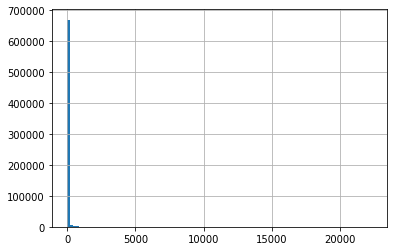

In [137]:
concat_df['총주차수'].hist(bins=100)

<AxesSubplot:>

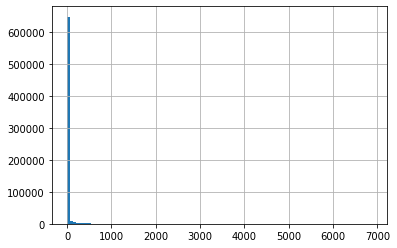

In [138]:
concat_df['총호수'].hist(bins=100)

In [141]:
main_data_df = pd.read_csv('./prepped_data/main_data_baseline_checkpoint_2.csv')

In [146]:
main_data_df.shape

(4441256, 17)

In [143]:
concat_df.rename(columns={'기준년도':'년'}, inplace=True)

In [144]:
merge_df = main_data_df.merge(concat_df, on=['지번주소', '년'])
print(merge_df.shape)

(2859818, 39)


In [145]:
merge_df.head()

,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,도로명주소,X좌표,Y좌표,최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,총주차수,epi점수,친환경점수,대장종류
0,매매,77.75,29,55000,0,7,1988,707.395498,2014,1,10.915088,6.561590,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,1988.0,1,0.0,528.17,5321.05,4736.87,54,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,표제부
1,매매,77.75,10,59500,0,4,1988,765.273312,2014,11,10.993732,6.640233,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,1988.0,1,0.0,528.17,5321.05,4736.87,54,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,표제부
2,전세,77.75,21,33000,0,2,1988,424.437299,2014,1,10.404263,6.050764,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,1988.0,1,0.0,528.17,5321.05,4736.87,54,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,표제부
3,전세,77.75,9,39000,0,9,1988,501.607717,2014,5,10.571317,6.217818,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,1988.0,1,0.0,528.17,5321.05,4736.87,54,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,표제부
4,전세,77.75,18,33000,0,1,1988,424.437299,2014,5,10.404263,6.050764,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,1988.0,1,0.0,528.17,5321.05,4736.87,54,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,표제부


In [147]:
merge_df['총호수'].describe()

count    2.859818e+06
mean     6.786053e+02
std      1.071545e+03
min      0.000000e+00
25%      1.600000e+01
50%      2.560000e+02
75%      8.540000e+02
max      6.864000e+03
Name: 총호수, dtype: float64

In [148]:
zero_df = merge_df[merge_df['총호수'] == 0]
zero_df.shape

(35138, 39)

In [149]:
zero_df.head()

,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,도로명주소,X좌표,Y좌표,최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,총주차수,epi점수,친환경점수,대장종류
65171,매매,84.87,22,92300,0,9,2010,1087.545658,2014,2,11.432799,6.991679,아파트,서울특별시 강남구 역삼동 762-3,서울특별시 강남구 도곡로 306-0,960090.442922,1.944002e+06,2011.0,1,20795.9,3538.473,77893.714,55399.028,0,5,12,22613.808,0,0.0,0,0.0,626,20582.352,0,0.0,626,0.0,0.0,총괄표제부
65172,매매,84.87,13,102500,0,16,2010,1207.729469,2014,3,11.537618,7.096497,아파트,서울특별시 강남구 역삼동 762-3,서울특별시 강남구 도곡로 306-0,960090.442922,1.944002e+06,2011.0,1,20795.9,3538.473,77893.714,55399.028,0,5,12,22613.808,0,0.0,0,0.0,626,20582.352,0,0.0,626,0.0,0.0,총괄표제부
65173,매매,84.87,15,97000,0,17,2010,1142.924473,2014,3,11.482466,7.041346,아파트,서울특별시 강남구 역삼동 762-3,서울특별시 강남구 도곡로 306-0,960090.442922,1.944002e+06,2011.0,1,20795.9,3538.473,77893.714,55399.028,0,5,12,22613.808,0,0.0,0,0.0,626,20582.352,0,0.0,626,0.0,0.0,총괄표제부
65174,매매,84.87,25,94300,0,14,2010,1111.111111,2014,4,11.454236,7.013116,아파트,서울특별시 강남구 역삼동 762-3,서울특별시 강남구 도곡로 306-0,960090.442922,1.944002e+06,2011.0,1,20795.9,3538.473,77893.714,55399.028,0,5,12,22613.808,0,0.0,0,0.0,626,20582.352,0,0.0,626,0.0,0.0,총괄표제부
65175,매매,84.87,5,98500,0,23,2010,1160.598563,2014,8,11.497812,7.056691,아파트,서울특별시 강남구 역삼동 762-3,서울특별시 강남구 도곡로 306-0,960090.442922,1.944002e+06,2011.0,1,20795.9,3538.473,77893.714,55399.028,0,5,12,22613.808,0,0.0,0,0.0,626,20582.352,0,0.0,626,0.0,0.0,총괄표제부


In [150]:
concat_df['총호수'].describe()

count    680558.000000
mean         28.029643
std         138.131776
min           0.000000
25%           7.000000
50%           9.000000
75%          12.000000
max        6864.000000
Name: 총호수, dtype: float64

<AxesSubplot:>

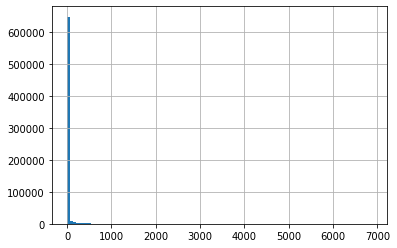

In [151]:
concat_df['총호수'].hist(bins=100)

In [152]:
concat_df.shape

(680558, 24)

In [153]:
zero_df = concat_df[concat_df['총호수'] == 0]
print(zero_df.shape)

(1200, 24)


In [154]:
one_df = concat_df[concat_df['총호수'] == 1]
one_df.shape

(151, 24)

In [155]:
concat_df.head()

,지번주소,년,최초사용승인일,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥내기계식면적,옥외기계식대수,옥외기계식면적,옥내자주식대수,옥내자주식면적,옥외자주식대수,옥외자주식면적,총주차수,epi점수,친환경점수,대장종류
0,서울특별시 강남구 개포동 1163-4,2014,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
1,서울특별시 강남구 개포동 1163-4,2015,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
2,서울특별시 강남구 개포동 1163-4,2016,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
3,서울특별시 강남구 개포동 1163-4,2017,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부
4,서울특별시 강남구 개포동 1163-4,2018,2013.0,0,336.1,167.78,1102.75,839.39,20,1,0,0.0,0,0.0,0,0.0,9,138.0,0,0.0,9,0.0,0.0,표제부


In [156]:
from sklearn.ensemble import IsolationForest

In [169]:
prac_df = concat_df[['총연면적', '총호수', '총주차수']]
prac_df.head()

,총연면적,총호수,총주차수
0,1102.75,20,9
1,1102.75,20,9
2,1102.75,20,9
3,1102.75,20,9
4,1102.75,20,9


In [162]:
prac_df.shape

(680558, 5)

In [170]:
clf = IsolationForest()

In [171]:
result = clf.fit_predict(prac_df)

In [173]:
prac_df['outlier'] = result

In [174]:
prac_df['outlier'].describe()

count    680558.000000
mean          0.848792
std           0.528728
min          -1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: outlier, dtype: float64

In [175]:
prac_df['outlier'].value_counts()

 1    629105
-1     51453
Name: outlier, dtype: int64

In [176]:
outlier_df = prac_df[prac_df['outlier'] == -1]
outlier_df.shape

(51453, 4)

In [177]:
outlier_df.head(100)

,총연면적,총호수,총주차수,outlier
78,3649.64000,23,31,-1
79,3649.64000,23,31,-1
80,3649.64000,23,31,-1
81,3649.64000,23,31,-1
82,3649.64000,23,31,-1
83,3649.64000,23,31,-1
84,3649.64000,23,31,-1
85,3315.54000,14,56,-1
86,3315.54000,14,56,-1
87,3315.54000,14,56,-1


In [178]:
inlier_df = prac_df[prac_df['outlier'] == 1]
inlier_df.shape

(629105, 4)

In [180]:
3649.64000 / 23

158.68

In [179]:
inlier_df.head(20)

,총연면적,총호수,총주차수,outlier
0,1102.75,20,9,1
1,1102.75,20,9,1
2,1102.75,20,9,1
3,1102.75,20,9,1
4,1102.75,20,9,1
5,1102.75,20,9,1
6,1102.75,20,9,1
7,827.86,11,8,1
8,827.86,11,8,1
9,827.86,11,8,1


In [186]:
prac_df.drop(columns=['outlier'], inplace=True)

In [187]:
%%time
clf = IsolationForest(n_estimators=1000, random_state=42, verbose=1)
result = clf.fit_predict(prac_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s finished


Wall time: 2min 43s


In [189]:
prac_df['outlier'] = result

In [190]:
prac_df['outlier'].value_counts()

 1    628536
-1     52022
Name: outlier, dtype: int64

In [191]:
prac_df = concat_df[['총연면적', '총호수', '총주차수']]

In [188]:
from sklearn.neighbors import LocalOutlierFactor

In [192]:
%%time
lof = LocalOutlierFactor()
result = lof.fit_predict(prac_df)

Wall time: 15.3 s


In [193]:
prac_df['outlier'] = result
prac_df['outlier'].value_counts()

 1    582189
-1     98369
Name: outlier, dtype: int64

In [194]:
outlier_df = prac_df[prac_df['outlier'] == -1]

In [195]:
outlier_df.head(20)

,총연면적,총호수,총주차수,outlier
57,1176.05,10,12,-1
58,1176.05,10,12,-1
59,1176.05,10,12,-1
60,1176.05,10,12,-1
61,1176.05,10,12,-1
62,1176.05,10,12,-1
63,1176.05,10,12,-1
64,1040.68,19,9,-1
65,1040.68,19,9,-1
66,1040.68,19,9,-1


In [197]:
scores = clf.score_samples(prac_df[['총연면적', '총호수', '총주차수']])

In [198]:
scores.shape

(680558,)

In [199]:
prac_df['outlier_score'] = scores

In [200]:
prac_df['outlier_score'].describe()

count    680558.000000
mean         -0.376246
std           0.089769
min          -0.878714
25%          -0.369665
50%          -0.346209
75%          -0.333053
max          -0.324973
Name: outlier_score, dtype: float64

<AxesSubplot:>

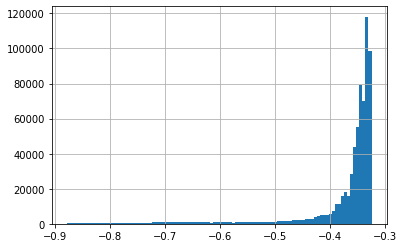

In [201]:
prac_df['outlier_score'].hist(bins=100)

In [202]:
min_df = prac_df[prac_df['outlier_score'] == prac_df['outlier_score'].min()]
min_df.shape

(7, 5)

In [203]:
min_df

,총연면적,총호수,총주차수,outlier,outlier_score
496184,1179648.09,6864,9766,1,-0.878714
496185,1179837.66,6864,9766,1,-0.878714
496186,1179837.66,6864,9766,1,-0.878714
496187,1179837.66,6864,9766,1,-0.878714
496188,1179837.66,6864,9766,1,-0.878714
496189,1179837.66,6864,9766,1,-0.878714
496190,1179837.66,6864,9766,1,-0.878714


In [204]:
1179648.09 / 6864

171.86015297202798

In [205]:
prac_df = concat_df[['총연면적', '총호수', '총주차수']]

In [208]:
%%time
clf = IsolationForest(random_state=42)
result = clf.fit_predict(prac_df)
scores = clf.score_samples(prac_df)

Wall time: 30.8 s


In [209]:
prac_df['outlier'] = result
prac_df['score'] = scores

<AxesSubplot:>

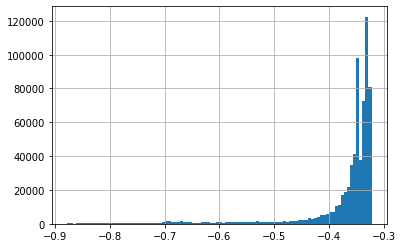

In [210]:
prac_df['score'].hist(bins=100)

In [211]:
min_df = prac_df[prac_df['score'] == prac_df['score'].min()]
print(min_df.shape)

(35, 5)


In [212]:
min_df

,총연면적,총호수,총주차수,outlier,score
30864,688558.450,3827,6140,-1,-0.877585
30865,688558.450,3827,6140,-1,-0.877585
30866,839026.856,5253,7167,-1,-0.877585
363024,712874.653,4452,5823,-1,-0.877585
363025,712874.653,4452,5823,-1,-0.877585
363026,712874.653,4452,5823,-1,-0.877585
363027,712874.653,4452,5823,-1,-0.877585
388574,813150.722,3410,6075,-1,-0.877585
388575,813150.722,3410,6075,-1,-0.877585
388576,813150.722,3410,6075,-1,-0.877585


In [214]:
prac_df = concat_df[['총연면적', '총호수', '총주차수']]

In [216]:
lof = LocalOutlierFactor()
result = lof.fit_predict(prac_df)

In [217]:
prac_df['outlier'] = result

In [218]:
prac_df['outlier'].value_counts()

 1    582189
-1     98369
Name: outlier, dtype: int64

In [219]:
outlier_df = prac_df[prac_df['outlier'] == -1]

In [220]:
outlier_df.head(50)

,총연면적,총호수,총주차수,outlier
57,1176.05,10,12,-1
58,1176.05,10,12,-1
59,1176.05,10,12,-1
60,1176.05,10,12,-1
61,1176.05,10,12,-1
62,1176.05,10,12,-1
63,1176.05,10,12,-1
64,1040.68,19,9,-1
65,1040.68,19,9,-1
66,1040.68,19,9,-1


In [222]:
outlier_df['총연면적'].describe()

count    9.836900e+04
mean     5.895778e+04
std      6.663568e+06
min      0.000000e+00
25%      3.540800e+02
50%      5.184100e+02
75%      6.589200e+02
max      8.516342e+08
Name: 총연면적, dtype: float64